# Static Pruning Benchmark
This script prunes a network model (post-training) iteratively and checks the models performance (Accuracy, Inference Time, etc.).
Inference time is measured on the CPU as well as on the GPU (if available).

For online pruning results we manually added scatter points into the plot. For further details please refer to the various training runs.

In [7]:
import time
import os
import json
import random
import numpy as np
import librosa
import hashlib
import sounddevice as sd
import matplotlib.pyplot as plt
import pickle as pkl
import dill as pickle
import datetime
from torchsummary import summary

import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader

from src.resnet import ResNet
from src.train import test
from src.dataset import GoogleSpeechCommandsDataset
import matplotlib.pyplot as plt

In [8]:
# Parameters
samples = 20
halving = False                     # halving = True iteratively prune | halving = True: equal pruning interval
halving_amount = 0.25
compare_with_random = False

use_cpu = False
is_spiking = False
path = 'models/'
model_name = 'resnet_ep55_acc94_sprs0.pt'  # 'resnet_ep56_acc95_sprs90.pth'  # 'resnet_ep55_acc99_sprs0.pt' 
data_test_dir = '/home/marcel/Source/Python/DLOptimization/data/speech_commands_test_set_v0.02'
data_cache_dir = '/home/marcel/Source/Python/DLOptimization/cache/data/'
load_data_from_dir = None

### Compute the benchmark

In [9]:
# Load model
torch.set_flush_denormal(True)
device = torch.device("cuda" if not use_cpu and torch.cuda.is_available() else "cpu")
model_path = str(os.path.join(path, model_name))
model = ResNet.from_state_dict(torch.load(model_path), spiking=is_spiking)
model.to(device)
rand_model = None
if compare_with_random:
    rand_model = ResNet.from_state_dict(torch.load(model_path), spiking=is_spiking)
    rand_model.to(device)
criterion = nn.CrossEntropyLoss()

In [4]:
# Load data
test_data = GoogleSpeechCommandsDataset(data_test_dir, data_cache_dir, encoder='mel', augment=0, train=False)
test_data.precache()
test_loader = DataLoader(test_data, batch_size=64 if not is_spiking else 8, shuffle=True)

--- Test Dataset ---
Path:	/home/marcel/Source/Python/DLOptimization/data/speech_commands_test_set_v0.02
Cache:	/home/marcel/Source/Python/DLOptimization/cache/data/speech_commands_test_set_v0.02
Labels:	('up', 'down', 'left', 'right', 'go', 'stop', 'yes', 'no', 'on', 'off')
Length:	4074


/home/marcel/Source/Python/Sketchbook/venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [16]:
accuracy, sparsity, significance, gpu_time, cpu_time_mean, cpu_time_std, num_params = test(model, test_loader, criterion, 
                                                                                           cpu_tests=32, return_time=True, log_interval=10, num_steps=10, device=device)


--- Test Results ---
-> Accuracy Validation on CUDA
Test [0/4074 (0%)]	Correct: 5/4074	ACC: 0.12%	Epoch: None
Test [80/4074 (2%)]	Correct: 30/4074	ACC: 0.74%	Epoch: None
Test [160/4074 (4%)]	Correct: 64/4074	ACC: 1.57%	Epoch: None
Test [240/4074 (6%)]	Correct: 94/4074	ACC: 2.31%	Epoch: None
Test [320/4074 (8%)]	Correct: 126/4074	ACC: 3.09%	Epoch: None
Test [400/4074 (10%)]	Correct: 156/4074	ACC: 3.83%	Epoch: None
Test [480/4074 (12%)]	Correct: 194/4074	ACC: 4.76%	Epoch: None
Test [560/4074 (14%)]	Correct: 223/4074	ACC: 5.47%	Epoch: None
Test [640/4074 (16%)]	Correct: 265/4074	ACC: 6.50%	Epoch: None
Test [720/4074 (18%)]	Correct: 302/4074	ACC: 7.41%	Epoch: None
Test [800/4074 (20%)]	Correct: 327/4074	ACC: 8.03%	Epoch: None
Test [880/4074 (22%)]	Correct: 370/4074	ACC: 9.08%	Epoch: None
Test [960/4074 (24%)]	Correct: 397/4074	ACC: 9.74%	Epoch: None
Test [1040/4074 (25%)]	Correct: 424/4074	ACC: 10.41%	Epoch: None
Test [1120/4074 (27%)]	Correct: 456/4074	ACC: 11.19%	Epoch: None
Test [1200/

In [5]:
# Prune and test
acc_list = []
sps_list = []
gpu_list = []
cpu_list = []
cpu_std_list = []
sig_list = []
prm_list = []

rand_acc_list = []
rand_sps_list = []
rand_gpu_list = []
rand_cpu_list = []
rand_cpu_std_list = []
rand_sig_list = []
rand_prm_list = []

prune_step = 1 / samples
for i in range(0, samples):
    if not halving:
        if model is not None:
            del model
        # Reload model
        model = ResNet.from_state_dict(torch.load(model_path), spiking=is_spiking)
        model.to(device)
        if compare_with_random:
            rand_model = ResNet.from_state_dict(torch.load(model_path), spiking=is_spiking)
            rand_model.to(device)
        
        amount = prune_step * i
    else:
        amount = 0
        if i > 0:
            amount = halving_amount
    
    if amount > 0:
        model.prune(name='weight', amount=amount)
        model.apply_pruning()
        if compare_with_random:
            rand_model.prune(random=True, name='weight', amount=amount)
            rand_model.apply_pruning()

    print('\n>> Weight Pruned Model:')
    accuracy, sparsity, significance, gpu_time, cpu_time_mean, cpu_time_std, num_params = test(model, test_loader, criterion, 
                                                                                               cpu_tests=32, return_time=True, log_interval=10, num_steps=5, device=device)
    acc_list.append(accuracy)
    sps_list.append(sparsity)
    gpu_list.append(gpu_time)
    cpu_list.append(cpu_time_mean)
    cpu_std_list.append(cpu_time_std)
    sig_list.append(significance)
    prm_list.append(num_params)
    
    if compare_with_random:
        print('\n>> Random Pruned Model:')
        accuracy, sparsity, significance, gpu_time, cpu_time_mean, cpu_time_std, num_params = test(rand_model, test_loader, criterion, 
                                                                                                   cpu_tests=32, return_time=True, log_interval=10, num_steps=5, device=device)
        rand_acc_list.append(accuracy)
        rand_sps_list.append(sparsity)
        rand_gpu_list.append(gpu_time)
        rand_cpu_list.append(cpu_time_mean)
        rand_cpu_std_list.append(cpu_time_std)
        rand_sig_list.append(significance)
        rand_prm_list.append(num_params)


>> Weight Pruned Model:

--- Test Results ---
-> Accuracy Validation on CUDA
Test [0/4074 (0%)]	Correct: 7/4074	ACC: 0.17%	Epoch: None
Test [80/4074 (2%)]	Correct: 45/4074	ACC: 1.10%	Epoch: None
Test [160/4074 (4%)]	Correct: 85/4074	ACC: 2.09%	Epoch: None
Test [240/4074 (6%)]	Correct: 122/4074	ACC: 2.99%	Epoch: None
Test [320/4074 (8%)]	Correct: 160/4074	ACC: 3.93%	Epoch: None
Test [400/4074 (10%)]	Correct: 196/4074	ACC: 4.81%	Epoch: None
Test [480/4074 (12%)]	Correct: 237/4074	ACC: 5.82%	Epoch: None
Test [560/4074 (14%)]	Correct: 276/4074	ACC: 6.77%	Epoch: None
Test [640/4074 (16%)]	Correct: 316/4074	ACC: 7.76%	Epoch: None
Test [720/4074 (18%)]	Correct: 354/4074	ACC: 8.69%	Epoch: None
Test [800/4074 (20%)]	Correct: 390/4074	ACC: 9.57%	Epoch: None
Test [880/4074 (22%)]	Correct: 427/4074	ACC: 10.48%	Epoch: None
Test [960/4074 (24%)]	Correct: 465/4074	ACC: 11.41%	Epoch: None
Test [1040/4074 (25%)]	Correct: 502/4074	ACC: 12.32%	Epoch: None
Test [1120/4074 (27%)]	Correct: 543/4074	ACC: 13

/home/marcel/Source/Python/EfficientNN/src/train.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(data, dtype=torch.float32)



>> Weight Pruned Model:

--- Test Results ---
-> Accuracy Validation on CUDA
Test [0/4074 (0%)]	Correct: 5/4074	ACC: 0.12%	Epoch: None
Test [80/4074 (2%)]	Correct: 39/4074	ACC: 0.96%	Epoch: None
Test [160/4074 (4%)]	Correct: 68/4074	ACC: 1.67%	Epoch: None
Test [240/4074 (6%)]	Correct: 112/4074	ACC: 2.75%	Epoch: None
Test [320/4074 (8%)]	Correct: 147/4074	ACC: 3.61%	Epoch: None
Test [400/4074 (10%)]	Correct: 182/4074	ACC: 4.47%	Epoch: None
Test [480/4074 (12%)]	Correct: 222/4074	ACC: 5.45%	Epoch: None
Test [560/4074 (14%)]	Correct: 257/4074	ACC: 6.31%	Epoch: None
Test [640/4074 (16%)]	Correct: 295/4074	ACC: 7.24%	Epoch: None
Test [720/4074 (18%)]	Correct: 336/4074	ACC: 8.25%	Epoch: None
Test [800/4074 (20%)]	Correct: 366/4074	ACC: 8.98%	Epoch: None
Test [880/4074 (22%)]	Correct: 404/4074	ACC: 9.92%	Epoch: None
Test [960/4074 (24%)]	Correct: 438/4074	ACC: 10.75%	Epoch: None
Test [1040/4074 (25%)]	Correct: 477/4074	ACC: 11.71%	Epoch: None
Test [1120/4074 (27%)]	Correct: 518/4074	ACC: 12.

### Save the benchmark

In [7]:
ct = datetime.datetime.now()
with open(f'./runs/prunebench/prunebench_{model_name.split(".")[0]}_{ct.strftime("%Y-%m-%d_%H-%M")}.pkl', 'wb') as f:
    pkl.dump({'acc': acc_list, 'sps': sps_list, 'gpu': gpu_list, 'cpu': cpu_list, 'cpu_std': cpu_std_list, 'sig': sig_list, 'prm': prm_list,
                 'rand_acc': rand_acc_list, 'rand_sps': rand_sps_list, 'rand_gpu': rand_gpu_list, 
                 'rand_cpu': rand_cpu_list, 'rand_cpu_std': rand_cpu_std_list, 'rand_sig': rand_sig_list, 'rand_prm': rand_prm_list}, f)

### Load a benchmark from file

In [8]:
if load_data_from_dir is not None:
    with open(load_data_from_dir, 'rb') as f:
        data = pkl.load(f)
        acc_list = data['acc']
        sps_list = data['sps']
        gpu_list = data['gpu']
        cpu_list = data['cpu']
        sig_list = data['sig']
        prm_list = data['prm']
        rand_acc_list = data['rand_acc']
        rand_sps_list = data['rand_sps']
        rand_gpu_list = data['rand_gpu']
        rand_cpu_list = data['rand_cpu']
        rand_sig_list = data['rand_sig']
        rand_prm_list = data['rand_prm']

### Visualize the benchmark

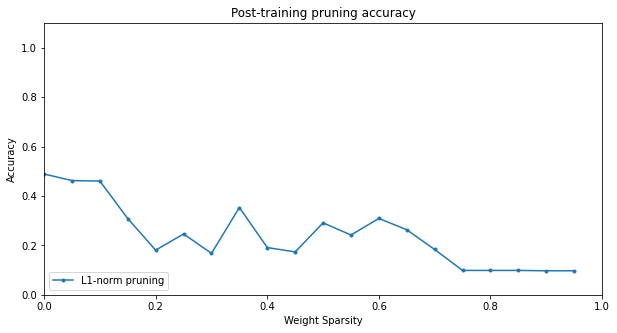

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(sps_list, acc_list, marker='.', label='L1-norm pruning')
if len(rand_acc_list) > 0:
    plt.plot(rand_sps_list, rand_acc_list, marker='.', label='Random pruning')
# plt.scatter([0.25, 0.4375, 0.5781, 0.6836, 0.7627], [0.9816, 0.9369, 0.8991, 0.9381, 0.9256], marker='o', color='darkred')
plt.title('Post-training pruning accuracy')
plt.xlabel('Weight Sparsity')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.ylim(0, 1.1)
plt.xlim(0, 1)
plt.show()

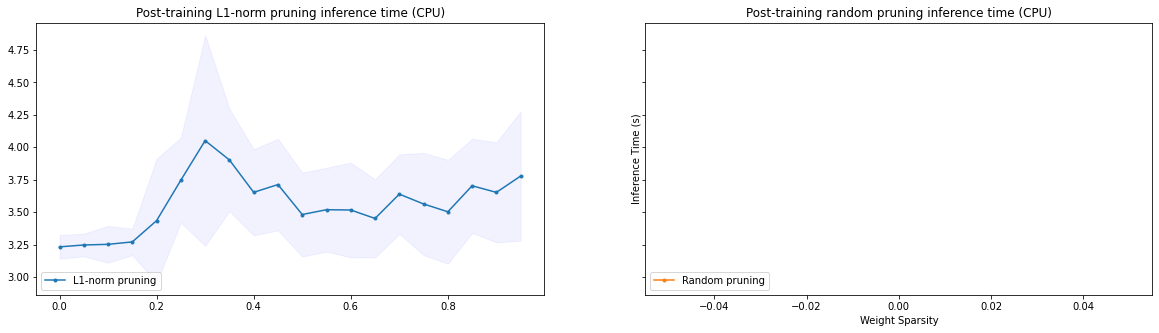

In [11]:
# plt.figure(figsize=(10, 5))
fig, sub = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

# L1-norm pruning plot
sub[0].plot(sps_list, cpu_list, marker='.', label='L1-norm pruning', c='C0')
sub[0].fill_between(sps_list, 
                 [m - s for m, s in zip(cpu_list, cpu_std_list)], 
                 [m + s for m, s in zip(cpu_list, cpu_std_list)], 
                 color='blue', alpha=0.05)
sub[0].legend(loc='lower left')
sub[0].set_title('Post-training L1-norm pruning inference time (CPU)')

# Random pruning plot
sub[1].plot(rand_sps_list, rand_cpu_list, marker='.', label='Random pruning', c='C1')
sub[1].fill_between(rand_sps_list, 
                 [m - s for m, s in zip(rand_cpu_list, rand_cpu_std_list)], 
                 [m + s for m, s in zip(rand_cpu_list, rand_cpu_std_list)], 
                 color='orange', alpha=0.05)
sub[1].legend(loc='lower left')
sub[1].set_title('Post-training random pruning inference time (CPU)')

#plt.plot(sps_list, cpu_list, marker='.', label='L1-norm pruning')
#plt.plot(rand_sps_list, rand_cpu_list, marker='.', label='Random pruning')
plt.xlabel('Weight Sparsity')
plt.ylabel('Inference Time (s)')
# plt.ylim(0.4, 1.0)

plt.show()

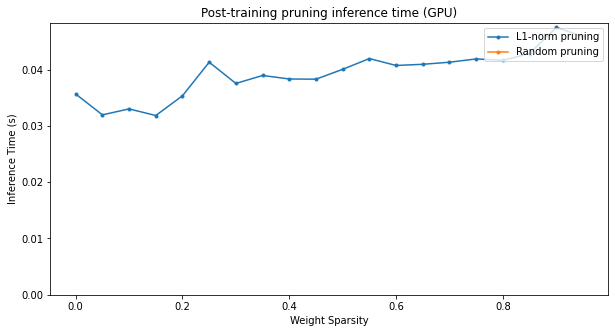

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(sps_list, gpu_list, marker='.', label='L1-norm pruning')
plt.plot(rand_sps_list, rand_gpu_list, marker='.', label='Random pruning')
plt.title('Post-training pruning inference time (GPU)')
plt.xlabel('Weight Sparsity')
plt.ylabel('Inference Time (s)')
plt.legend(loc='upper right')
plt.ylim(0)
plt.show()

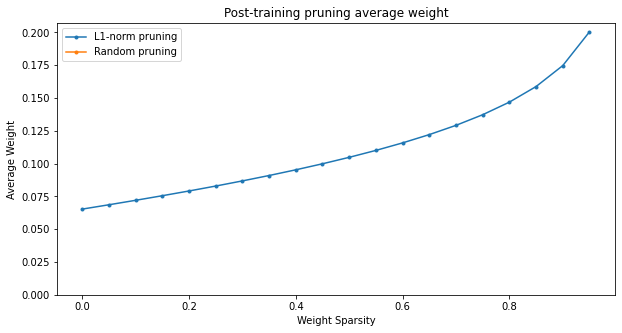

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(sps_list, sig_list, marker='.', label='L1-norm pruning')
plt.plot(rand_sps_list, rand_sig_list, marker='.', label='Random pruning')
plt.title('Post-training pruning average weight')
plt.xlabel('Weight Sparsity')
plt.ylabel('Average Weight')
plt.legend(loc='upper left')
plt.ylim(0)
plt.show()

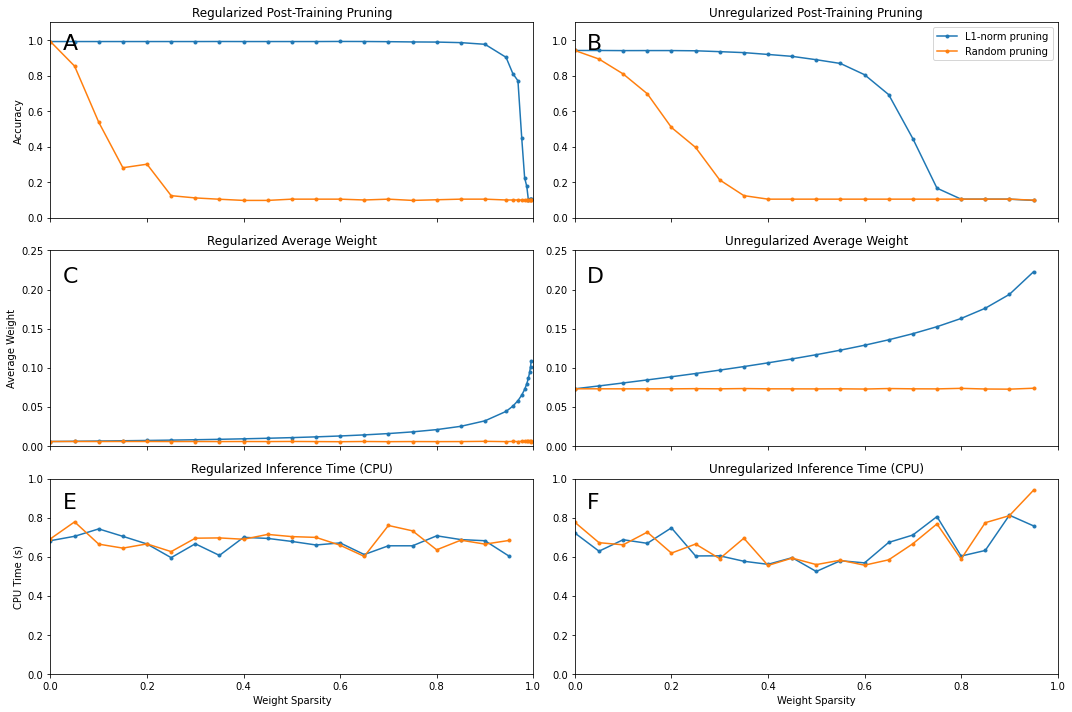

In [3]:
# Final Visualization
file = 'runs/prunebench/prunebench_resnet_ep55_acc94_sprs0_2024-01-27_02-05.pkl'
file2 = 'runs/prunebench/prunebench_resnet_ep55_acc99_sprs0_2024-01-22_11-43.pkl'
file3 = 'runs/prunebench/prunebench_resnet_ep55_acc99_sprs0_2024-01-07_21-25.pkl'
with open(file3, 'rb') as f3:
    with open(file, 'rb') as f:
        f_data = pkl.load(f)
        f3_data = pkl.load(f3)
        wd2_acc_list = f3_data['acc']
        wd2_sps_list = f3_data['sps']
        wd2_rand_acc_list = f3_data['rand_acc']
        wd2_sig_list = f3_data['sig']
        wd2_rand_sig_list = f3_data['rand_sig']
        wd2_cpu_list = f3_data['cpu']
        wd2_rand_cpu_list = f3_data['rand_cpu']
        wd_acc_list = f_data['acc']
        wd_sps_list = f_data['sps']
        wd_gpu_list = f_data['gpu']
        wd_cpu_list = f_data['cpu']
        wd_sig_list = f_data['sig']
        wd_prm_list = f_data['prm']
        wd_rand_acc_list = f_data['rand_acc']
        wd_rand_sps_list = f_data['rand_sps']
        wd_rand_gpu_list = f_data['rand_gpu']
        wd_rand_cpu_list = f_data['rand_cpu']
        wd_rand_sig_list = f_data['rand_sig']
        wd_rand_prm_list = f_data['rand_prm']
with open(file2, 'rb') as f2:
    f2_data = pkl.load(f2)
    nwd_acc_list = f2_data['acc']
    nwd_sps_list = f2_data['sps']
    nwd_gpu_list = f2_data['gpu']
    nwd_cpu_list = f2_data['cpu']
    nwd_sig_list = f2_data['sig']
    nwd_prm_list = f2_data['prm']
    nwd_rand_acc_list = f2_data['rand_acc']
    nwd_rand_sps_list = f2_data['rand_sps']
    nwd_rand_gpu_list = f2_data['rand_gpu']
    nwd_rand_cpu_list = f2_data['rand_cpu']
    nwd_rand_sig_list = f2_data['rand_sig']
    nwd_rand_prm_list = f2_data['rand_prm']

fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
axs[0,0].plot(nwd_sps_list[:-1] + wd2_sps_list[-10:], nwd_acc_list[:-1] + wd2_acc_list[-10:], marker='.', label='L1-norm pruning')
axs[0,1].plot(wd_sps_list, wd_acc_list, marker='.', label='L1-norm pruning')

axs[1,0].plot(nwd_sps_list[:-1] + wd2_sps_list[-10:], nwd_sig_list[:-1] + wd2_sig_list[-10:], marker='.', label='L1-norm pruning')
axs[1,1].plot(wd_sps_list, wd_sig_list, marker='.', label='L1-norm pruning')

axs[2,0].plot(nwd_sps_list, nwd_cpu_list, marker='.', label='L1-norm pruning')
axs[2,1].plot(wd_sps_list, wd_cpu_list, marker='.', label='L1-norm pruning')

if len(wd_rand_acc_list) > 0:
    axs[0,0].plot(nwd_rand_sps_list[:-1] + wd2_sps_list[-10:], nwd_rand_acc_list[:-1] + wd2_rand_acc_list[-10:], marker='.', label='Random pruning')
    axs[0,1].plot(wd_rand_sps_list, wd_rand_acc_list, marker='.', label='Random pruning')
    
    axs[1,0].plot(nwd_sps_list[:-1] + wd2_sps_list[-10:], nwd_rand_sig_list[:-1] + wd2_rand_sig_list[-10:], marker='.', label='Random pruning')
    axs[1,1].plot(wd_sps_list, wd_rand_sig_list, marker='.', label='Random pruning')
    
    axs[2,0].plot(nwd_sps_list, nwd_rand_cpu_list, marker='.', label='Random pruning')
    axs[2,1].plot(wd_sps_list, wd_rand_cpu_list, marker='.', label='Random pruning')

axs[0,0].set_title('Regularized Post-Training Pruning')
axs[1,0].set_title('Regularized Average Weight')
axs[2,0].set_title('Regularized Inference Time (CPU)')
axs[0,1].set_title('Unregularized Post-Training Pruning')
axs[1,1].set_title('Unregularized Average Weight')
axs[2,1].set_title('Unregularized Inference Time (CPU)')
axs[2,0].set_xlabel('Weight Sparsity')
axs[2,1].set_xlabel('Weight Sparsity')
axs[0,0].set_ylabel('Accuracy')
axs[1,0].set_ylabel('Average Weight')
axs[2,0].set_ylabel('CPU Time (s)')
axs[0,0].set_ylim(0, 1.1)
axs[0,0].set_xlim(0, 1)
axs[0,1].set_ylim(0, 1.1)
axs[0,1].set_xlim(0, 1)
axs[1,0].set_ylim(0, 0.25)
axs[1,1].set_ylim(0, 0.25)
axs[2,0].set_ylim(0, 1.)
axs[2,1].set_ylim(0, 1.)
axs[0,1].legend(loc='upper right')
axs[0,0].text(0.025, 0.95, 'A', fontsize=22)
axs[0,1].text(0.025, 0.95, 'B', fontsize=22)
axs[1,0].text(0.025, 0.21, 'C', fontsize=22)
axs[1,1].text(0.025, 0.21, 'D', fontsize=22)
axs[2,0].text(0.025, 0.85, 'E', fontsize=22)
axs[2,1].text(0.025, 0.85, 'F', fontsize=22)
plt.tight_layout()
plt.show()

In [19]:
import statistics
cpu_time_mean = sum(wd_cpu_list[:5]) / len(wd_cpu_list[:5])
cpu_time_std = statistics.stdev(wd_cpu_list[:5])
print(f'Time: {cpu_time_mean:.4f}±{cpu_time_std:.2f} s')

Time: 0.6903±0.05 s


In [13]:
summary(model, input_size=(1, 128, 111))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1          [-1, 1, 128, 111]               0
            Conv2d-2        [-1, 128, 128, 111]           1,152
       BatchNorm2d-3        [-1, 128, 128, 111]             256
              ReLU-4        [-1, 128, 128, 111]               0
            Conv2d-5        [-1, 128, 128, 111]         147,456
       BatchNorm2d-6        [-1, 128, 128, 111]             256
              ReLU-7        [-1, 128, 128, 111]               0
            Conv2d-8        [-1, 128, 128, 111]         147,456
       BatchNorm2d-9        [-1, 128, 128, 111]             256
      DeQuantStub-10        [-1, 128, 128, 111]               0
      DeQuantStub-11        [-1, 128, 128, 111]               0
        QuantStub-12        [-1, 128, 128, 111]               0
             ReLU-13        [-1, 128, 128, 111]               0
         ResBlock-14        [-1, 128, 1